# Decision Trees

In [3]:
# Import necessary modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint

In [4]:
#insert the desired path containing combined data files
path = os.path.expanduser(r"~/Documents/python/identification_modified_proteins/bin_size_0.01/")

#changes current working directory to the path given 
directory = os.chdir(path)

#load data 
load_data = np.load('all_train_data_0.01_with_2+.npy', allow_pickle=True)
inten_df = pd.DataFrame(load_data)

# Create feature and target arrays
X = inten_df.drop(101300, axis=1) 
y = inten_df[101300].astype('int') #last column is the modified or not modified feature

In [5]:
#split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4 , random_state=42)

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Fit the classifier to the training data
tree.fit(X_train, y_train)

# Print the accuracy
print(tree.score(X_test, y_test))

1.0


In [6]:
print("Test set predictions: {}".format(tree.predict(X_test)))
print("Test set accuracy: {:.2f}".format(tree.score(X_test, y_test)))

Test set predictions: [0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1]
Test set accuracy: 1.00


Increased accuracy when using extended dataset.

In [7]:
#fit classifier
tree.fit(X_train, y_train)

#predict using the X_test data
y_pred_rf = tree.predict(X_test)

#build dataframe to house the scores.
df = pd.DataFrame()

#name columns
cols = ['Machine Learning Classification Method',
        'Train Accuracy', 
        'Test Accuracy']

#name required cells 
df.loc['Machine Learning Classification Method', 
       'Details'] = 'Desicion Tree'

#fit classifier onto both datasets to compare 
df.loc['Train Accuracy', 'Details'] = tree.score(X_train, y_train) 
df.loc['Test Accuracy', 'Details'] = tree.score(X_test, y_test)
print(df)

                                              Details
Machine Learning Classification Method  Desicion Tree
Train Accuracy                                      1
Test Accuracy                                0.947368


Very slight improvement in test accuracy.

In [8]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 101300),
              "min_samples_leaf": randint(1, 101300),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 68150, 'min_samples_leaf': 41868}
Best score is 0.6088888888888888


Confusion matrix to evaluate model. 

In [9]:
#fit the classifier to the training data
tree.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = tree.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10  0]
 [ 1  8]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.89      0.94         9

    accuracy                           0.95        19
   macro avg       0.95      0.94      0.95        19
weighted avg       0.95      0.95      0.95        19



Reviewed the affect of scaling.

In [10]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('knn', DecisionTreeClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: knn_scaled
tree_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
tree_unscaled = tree.fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(tree_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(tree_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 1.0
Accuracy without Scaling: 0.9473684210526315


As can be seen, a much smaller discrepency can be seen when data is scaled unlike that of SVM using the extended data. 

## PCA 
Note we start with 16 principal components as this is what was first identified without a classifier that was the minimum number of components to meet the target of only 10% explained variance loss.

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Scaling improved score and thus is kept. 

In [13]:
#build the pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=16)),
        ('classifier', DecisionTreeClassifier())])

#fit the pipeline to the training data
pipe.fit(X_train, y_train)

#score the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

#prints the explained variance ratio and accuracy
print(pipe.steps[1][1].explained_variance_ratio_)
print('{0:.1%} test set accuracy'.format(accuracy))

[0.27512629 0.09226276 0.07788127 0.05766278 0.05351533 0.04992562
 0.04754853 0.04384599 0.04052781 0.03877501 0.03730112 0.0309969
 0.02703635 0.02537425 0.01709722 0.01563782]
42.1% test set accuracy


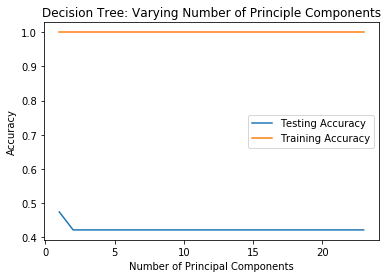

In [14]:
# Setup arrays to store train and test accuracies
n_components = np.arange(1, 24)
train_accuracy = np.empty(len(n_components))
test_accuracy = np.empty(len(n_components))

# Loop over different values of k
for i, k in enumerate(n_components):
    
    #setup a pipeline with a k-NN Classifier with k neighbors: knn
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=k)),
        ('classifier', DecisionTreeClassifier())])

    #fit the pipeline to to the training data
    pipe.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = pipe.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = pipe.score(X_test, y_test)

# Generate plot
plt.title('Decision Tree: Varying Number of Principle Components')
plt.plot(n_components, test_accuracy, label = 'Testing Accuracy')
plt.plot(n_components, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.show()

It seems that there is a higher degree of overfitting when using the extended dataset with this classifier. It is more prominent now given the comparison of much lower testing accuracy of this dataset compared to the testing accuracy of the dataset only consisting of 1+ masses. 